## Configuração do Ambiente e Importação de Bibliotecas

Esta é a célula de setup principal para o notebook. Todas as bibliotecas necessárias para a análise são importadas aqui para garantir a organização e a clareza do código.

Além das importações, esta célula também define:
-   Os caminhos para as pastas do projeto (`data`, `figures`, etc.).
-   Configurações globais para a aparência dos gráficos (`seaborn` e `matplotlib`).
-   Filtros para ignorar avisos de depreciação (`warnings`).

In [17]:
# Célula de Importação e Configuração do Ambiente
import re
import nltk
import torch
from collections import Counter
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import Dataset
from wordcloud import WordCloud
from tqdm.auto import tqdm
from IPython.display import display
from transformers import pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

# Dowload de dados do NLTK
# O 'quiet=True' evita poluir o output se os dados já estiverem baixados.
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

# Definição de variáveis de caminho
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_RAW_DIR = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED_DIR = PROJECT_ROOT / 'data' / 'processed'
FIGURES_DIR = PROJECT_ROOT / 'figures'
SCRIPTS_DIR = PROJECT_ROOT / 'scripts'

print(f"Ambiente configurado. Raiz do projeto: {PROJECT_ROOT}")

Ambiente configurado. Raiz do projeto: /home/henrique/Documentos/UFV2025/RedesComplexas/ProjetoRedes


In [2]:
# Carrega o dataset de comentários
arquivo_comentarios = DATA_RAW_DIR / 'comentarios.csv'
df = pd.read_csv(arquivo_comentarios)

# Exibe as informações básicas do DataFrame (tipos de dados, valores não nulos)
print("Informações básicas do DataFrame:")
df.info()

# Exibe as 5 primeiras linhas para uma primeira olhada
print("\nAs 5 primeiras linhas do dataset:")
display(df.head())

# Conta o número de participantes únicos
participantes_unicos = df['author'].nunique()
print(f"\nNúmero total de participantes únicos: {participantes_unicos}")

# Exibe os 10 comentários com mais likes
print("\nTop 10 comentários com mais likes:")
display(df.sort_values(by='likes', ascending=False).head(10))

Informações básicas do DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282318 entries, 0 to 282317
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   comment_id  282318 non-null  object
 1   author      281849 non-null  object
 2   text        282247 non-null  object
 3   likes       282318 non-null  int64 
 4   timestamp   282318 non-null  object
 5   parent_id   30366 non-null   object
dtypes: int64(1), object(5)
memory usage: 12.9+ MB

As 5 primeiras linhas do dataset:


,comment_id,author,text,likes,timestamp,parent_id
0,Ugx6LlahwTy_MwZiJod4AaABAg,@AnaJúlya-t3d,Ta certo,0,2025-09-29T13:50:17Z,NaN
1,Ugxmtcz6oq7vAgtW5C94AaABAg,@EliasDaniel-y2o,Lei felca,0,2025-09-29T13:21:44Z,NaN
2,UgwZ2v_3Y8folAjlrEl4AaABAg,@EmanuelHeitorSilvaTorres,nojo,0,2025-09-29T11:10:33Z,NaN
3,UgzXc-9-_llf4i-JXu54AaABAg,@EmanuelHeitorSilvaTorres,O8:06 nojo 🤮,0,2025-09-29T11:06:46Z,NaN
4,UgwO8-fTdddUIS4OAjd4AaABAg,@EmanuelHeitorSilvaTorres,que nojo 🤮,0,2025-09-29T11:05:36Z,NaN



Número total de participantes únicos: 238965

Top 10 comentários com mais likes:


,comment_id,author,text,likes,timestamp,parent_id
205671,Ugyzo57XPO4-1W19EQp4AaABAg,@wellingtonlourenco5469,Ele lutou contra as lives de NPC\nEle lutou co...,498149,2025-08-08T21:16:15Z,NaN
180302,UgzsUvdsjJelj7ALqJt4AaABAg,@masgilmar,Perceberam que o FELCA não ativou a monetizaçã...,468339,2025-08-09T01:47:22Z,NaN
280617,UgwIQJJeWqUx9y8pCWV4AaABAg,@leniquexD,"Felca foi lá, cresceu honesto e engraçado. Peg...",373640,2025-08-07T03:10:03Z,NaN
253240,UgyH1UfvNx0xJECDFet4AaABAg,@deborasantos9848,"Isso deveria estar na Netflix, isso não é um v...",256710,2025-08-08T01:26:39Z,NaN
207353,UgwgZNVYt_jck8o291N4AaABAg,@fadereality,"Senhor, protege esse cara, Tem meu respeito!",199351,2025-08-08T21:07:30Z,NaN
278811,UgzAsspH6qcKHMx4Ypp4AaABAg,@Eiicristina,Protejam o felca!!! Esse é o tipo de denuncia...,184018,2025-08-07T04:07:37Z,NaN
279657,UgxL7-LS0cEH3kuCan94AaABAg,@adrianofernandes508,Felca se tornando o Batman da internet ta mto bom,167396,2025-08-07T03:42:20Z,NaN
217157,UgxHddudIKE9l8PzCAl4AaABAg,@cleidianearaujoo,Enfim alguém com um alcance absurdo teve corag...,163748,2025-08-08T19:08:08Z,NaN
121210,Ugwicq9Aar-B7l55_014AaABAg,@laurawaztaken,"eu como tradutora, vou fazer uma legenda em in...",150347,2025-08-09T23:12:36Z,NaN
264515,UgwK3BZYarIPOr0V4sR4AaABAg,@Rodrigo_Goes,"Felca, como pai de meninas o seu vídeo me fez ...",118978,2025-08-07T19:25:35Z,NaN


## Pré-processamento e Limpeza do Texto

Antes de qualquer análise de conteúdo, é fundamental preparar os dados textuais. Esta etapa consiste em uma série de transformações para normalizar o texto, removendo "ruídos" que podem atrapalhar os algoritmos de Processamento de Linguagem Natural (PLN).

O processo de limpeza incluirá:
-   Conversão para letras minúsculas.
-   Remoção de links (URLs).
-   Remoção de pontuação e caracteres especiais.
-   Tokenização (divisão do texto em palavras).
-   Remoção de *stopwords* (palavras comuns em português como 'e', 'de', 'para', que não agregam significado à análise).

O resultado será uma nova coluna em nosso DataFrame, `texto_limpo`, que servirá de base para as análises subsequentes.

In [3]:
# Carrega a lista de stopwords em português para uma variável
stop_words = set(stopwords.words('portuguese'))

# Define a função que fará a limpeza de um texto individual
def limpar_texto(texto):
    texto = texto.lower()
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto, flags=re.MULTILINE)
    texto = re.sub(r'[^\w\s]', '', texto)
    lista_palavras = texto.split()
    palavras_sem_stopwords = [palavra for palavra in lista_palavras if palavra not in stop_words]
    return " ".join(palavras_sem_stopwords)

# Aplica a função de limpeza na coluna 'text' usando o .apply() padrão
df['texto_limpo'] = df['text'].astype(str).apply(limpar_texto)

# Exibe o "antes e depois" para os 5 primeiros comentários, para verificação
print("Resultado da limpeza (Antes vs. Depois):")
display(df[['text', 'texto_limpo']].head())

Resultado da limpeza (Antes vs. Depois):


,text,texto_limpo
0,Ta certo,ta certo
1,Lei felca,lei felca
2,nojo,nojo
3,O8:06 nojo 🤮,o806 nojo
4,que nojo 🤮,nojo


## Análise Descritiva dos Comentários

Após o pré-processamento, foi realizada uma análise descritiva para compreender as características e a dinâmica da seção de comentários. Esta etapa foca em quatro eixos principais: a evolução temporal, o engajamento do público, o padrão de participação dos usuários e o conteúdo textual mais frequente.

**Questões de Pesquisa Específicas:**
-   Como o volume de comentários evoluiu ao longo do tempo após a publicação do vídeo?
-   Como o engajamento (medido em "likes") se distribui entre os comentários?
-   A discussão foi dominada por poucos usuários muito ativos ou distribuída entre muitos participantes?
-   Quais foram as palavras mais utilizadas no debate?

**Passos da Análise (Metodologia):**
* **Análise Temporal:** Plotar a quantidade de comentários por dia para visualizar o ciclo de vida da discussão.
* **Análise de Engajamento:** Analisar a distribuição de "likes" para entender a economia da atenção.
* **Análise de Participação:** Investigar a distribuição de comentários por autor para identificar "power users".
* **Análise de Frequência:** Contar as palavras individuais mais comuns e gerar uma nuvem de palavras para um resumo visual do conteúdo.

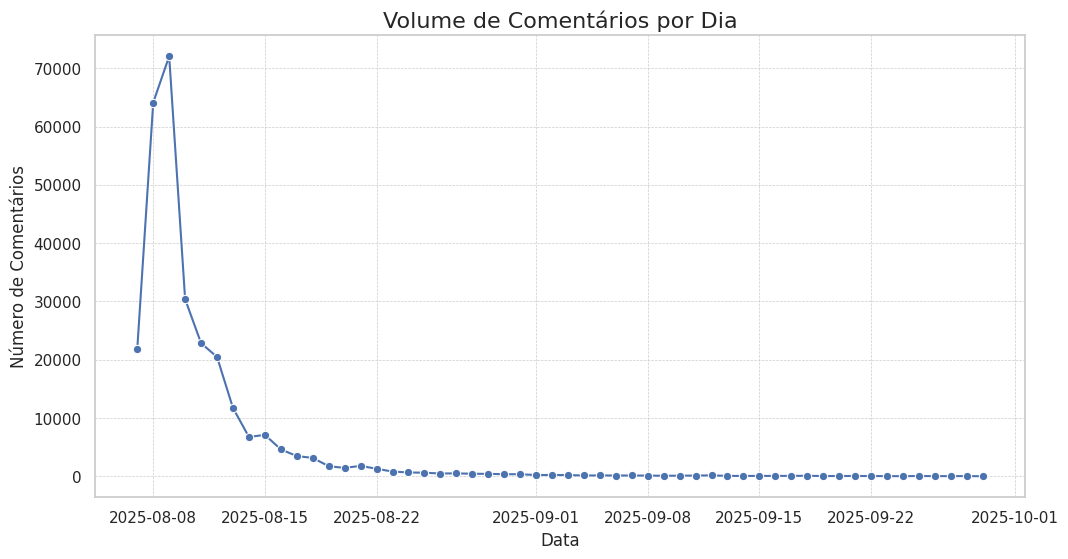

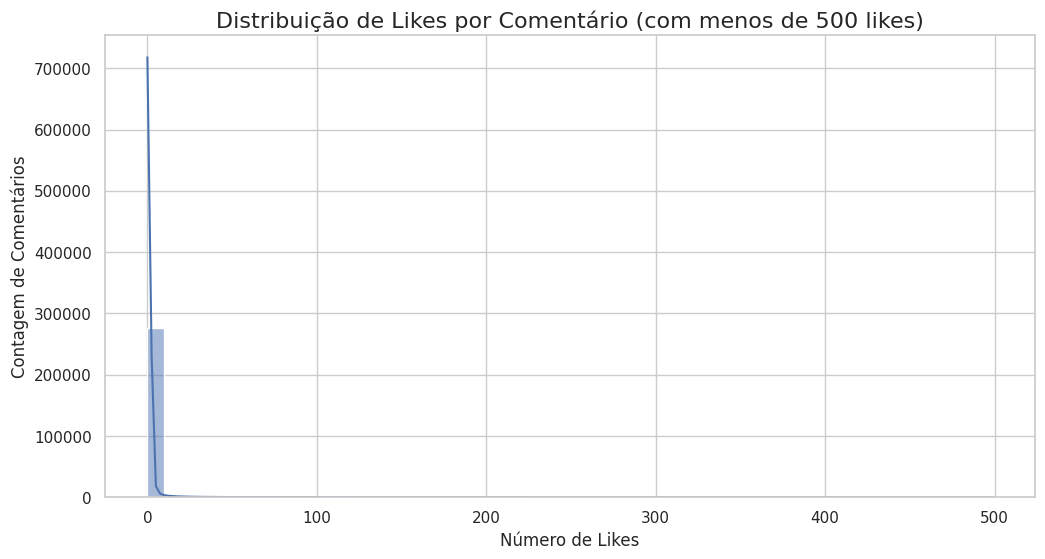

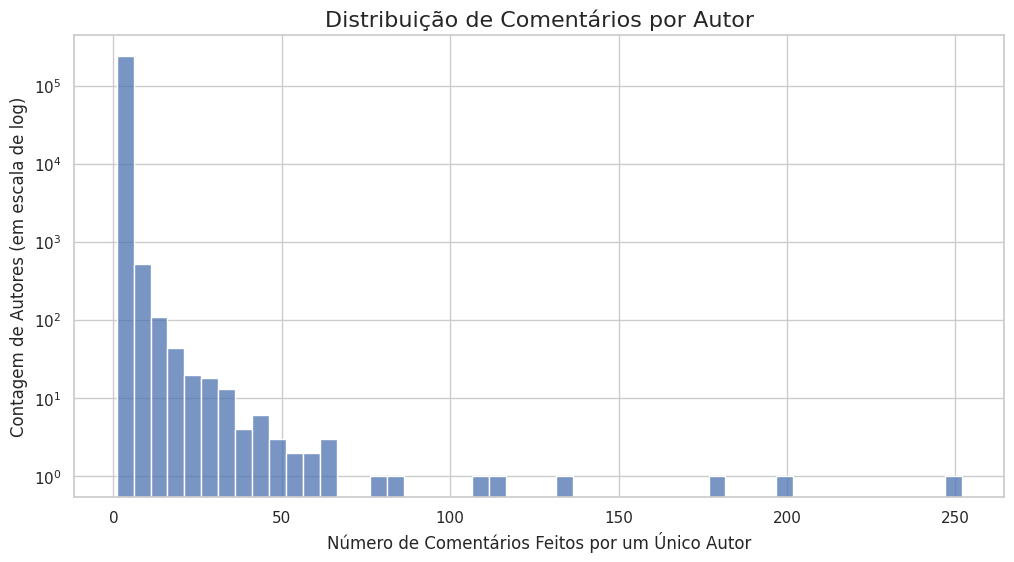

Top 15 autores mais ativos:


author
@katerineoliveira411        252
@Comunista_Enrustida6378    199
@ivi8060                    177
@adrianvantasset8081        132
@DarkDorly                  115
@JoaoPedro-lg9kj            109
@waldeniorocha               84
@totóigameplays              78
@temporariamente24h          66
@Lady-Lambdadelta            64
@danielaviana4778            62
@SantanaWithout4             61
@Loli-iw                     57
@Rosberg-e7u                 54
@Lockdoownn                  52
Name: count, dtype: int64

/tmp/ipykernel_3740/42573880.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequencia', y='palavra', data=df_palavras_comuns, palette='viridis')


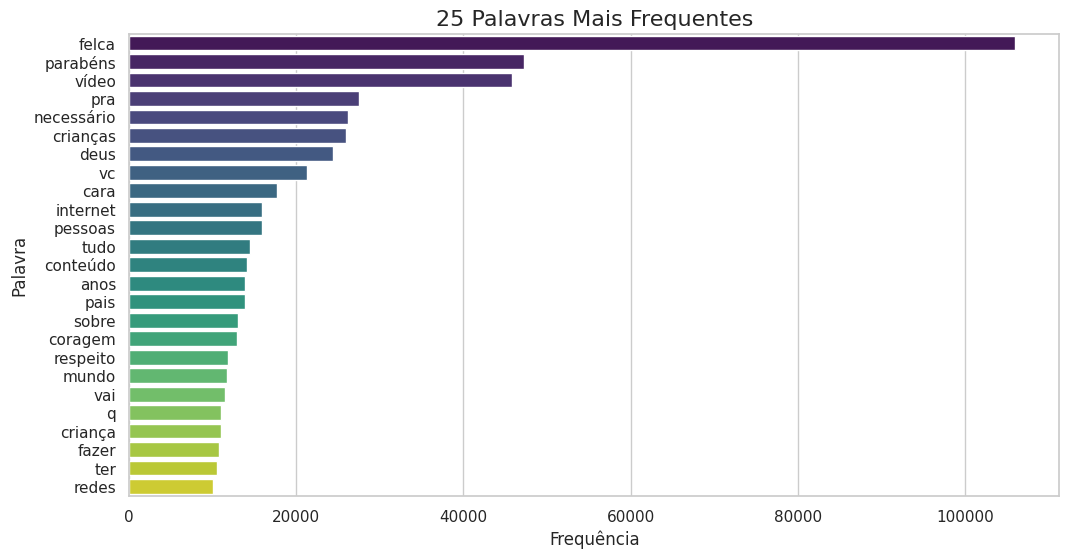

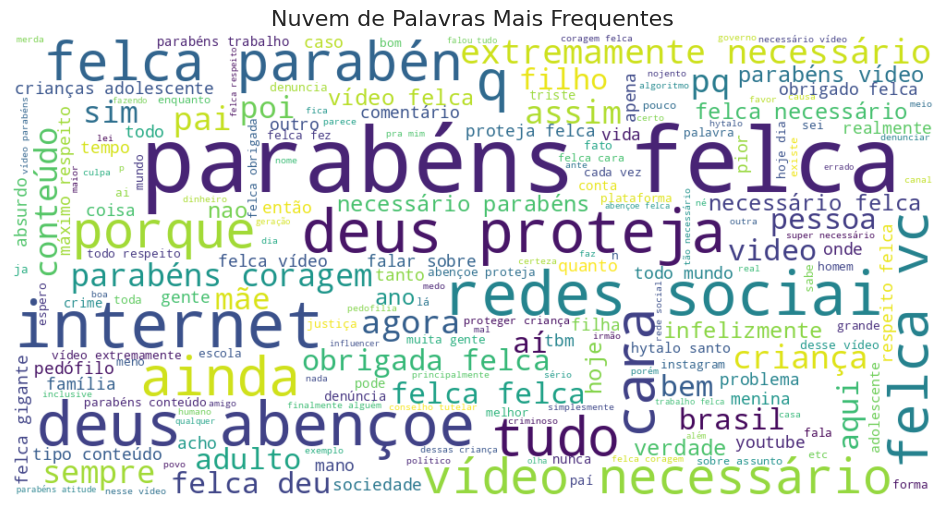

In [18]:
# Análise temporal
df['timestamp'] = pd.to_datetime(df['timestamp'])
comentarios_por_dia = df.set_index('timestamp').resample('D').size()

# Volume de comentários por dia
plt.figure(figsize=(12, 6))
sns.lineplot(data=comentarios_por_dia, marker='o')
plt.title('Volume de Comentários por Dia', fontsize=16)
plt.xlabel('Data')
plt.ylabel('Número de Comentários')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

# Distribuição de likes
plt.figure(figsize=(12, 6))
sns.histplot(df[df['likes'] < 500]['likes'], bins=50, kde=True)
plt.title('Distribuição de Likes por Comentário (com menos de 500 likes)', fontsize=16)
plt.xlabel('Número de Likes')
plt.ylabel('Contagem de Comentários')
plt.show()

# Análise de participação
comentarios_por_autor = df['author'].value_counts()

# Distribuição de comentários por autor
plt.figure(figsize=(12, 6))
sns.histplot(comentarios_por_autor, bins=50)
plt.yscale('log')
plt.title('Distribuição de Comentários por Autor', fontsize=16)
plt.xlabel('Número de Comentários Feitos por um Único Autor')
plt.ylabel('Contagem de Autores (em escala de log)')
plt.show()

print("Top 15 autores mais ativos:")
display(comentarios_por_autor.head(15))

# Frequência de palavras
nltk.download('punkt', quiet=True)
todas_as_palavras = [palavra for texto in df['texto_limpo'].dropna() for palavra in texto.split()]
contagem_palavras = Counter(todas_as_palavras)
df_palavras_comuns = pd.DataFrame(contagem_palavras.most_common(25), columns=['palavra', 'frequencia'])
plt.figure(figsize=(12, 6)) 
sns.barplot(x='frequencia', y='palavra', data=df_palavras_comuns, palette='viridis')
plt.title('25 Palavras Mais Frequentes', fontsize=16)
plt.xlabel('Frequência')
plt.ylabel('Palavra')
plt.show()

texto_completo = " ".join(todas_as_palavras)
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='viridis').generate(texto_completo)

# Nuvem de palavras
plt.figure(figsize=(12, 6)) 
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Nuvem de Palavras Mais Frequentes', fontsize=16)
plt.axis('off')
plt.show()

## Análise de Sentimento Básica com VADER

Após a análise descritiva, a próxima etapa é aprofundar a compreensão do conteúdo através da análise de sentimento. O objetivo é classificar a polaridade de cada comentário, determinando se ele expressa uma opinião positiva, negativa ou neutra.

Esta análise é fundamental para quantificar a tonalidade geral do debate e servirá de base para futuras análises cruzadas com a estrutura de rede.

**Passos da Análise (Metologia):**
* Utilizar uma biblioteca de análise de sentimento otimizada para o português do Brasil (LeIA - Léxico para Inferência Adaptada).
* Aplicar o modelo a cada comentário na coluna `texto_limpo` para obter uma pontuação de sentimento.
* Classificar cada comentário com base em sua pontuação.
* Agregar os resultados para visualizar a distribuição geral dos sentimentos.

Distribuição Geral dos Sentimentos:


,Contagem,Porcentagem (%)
sentimento,,
neutro,264234,93.59
positivo,11279,4.00
negativo,6805,2.41


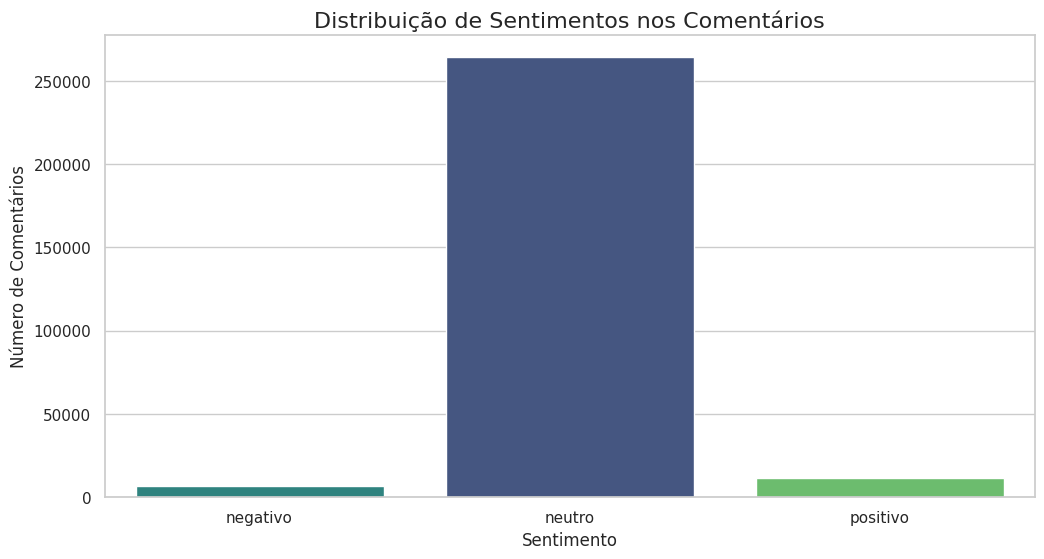

In [ ]:
# Baixa o léxico do VADER
nltk.download('vader_lexicon', quiet=True)

# Inicializa o analisador
analyzer = SentimentIntensityAnalyzer()

# Função para calcular e classificar o sentimento
def calcular_sentimento(texto):
    score = analyzer.polarity_scores(texto)
    compound_score = score['compound']
    if compound_score >= 0.05:
        return 'positivo'
    elif compound_score <= -0.05:
        return 'negativo'
    else:
        return 'neutro'

# Aplica a análise de sentimentos usando .apply()
df['sentimento'] = df['texto_limpo'].astype(str).apply(calcular_sentimento)

# Contagem e porcentagem
sentiment_counts = df['sentimento'].value_counts()
sentiment_percentages = df['sentimento'].value_counts(normalize=True) * 100

print("Distribuição Geral dos Sentimentos:")
display(pd.DataFrame({
    'Contagem': sentiment_counts,
    'Porcentagem (%)': sentiment_percentages.round(2)
}))

# Gráfico
plt.figure(figsize=(12, 6))
sns.countplot(x='sentimento', data=df,
              order=['negativo', 'neutro', 'positivo'],
              palette='viridis', hue='sentimento', legend=False)
plt.title('Distribuição de Sentimentos nos Comentários', fontsize=16)
plt.xlabel('Sentimento')
plt.ylabel('Número de Comentários')
plt.show()

# Calcula também a pontuação compound usando .apply()
df['pontuacao_sentimento'] = df['texto_limpo'].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)['compound']
)

print("\nTop 5 Comentários Mais Positivos:")
display(df.sort_values(by='pontuacao_sentimento', ascending=False)[['texto_limpo', 'pontuacao_sentimento']].head(5))

print("\nTop 5 Comentários Mais Negativos:")
display(df.sort_values(by='pontuacao_sentimento', ascending=True)[['texto_limpo', 'pontuacao_sentimento']].head(5))

## Análise de Sentimento Avançada com Transformers (BERTimbau)

Após a análise inicial com métodos léxicos, avançamos para uma abordagem de última geração utilizando modelos de linguagem baseados em transformers.  
O objetivo é aumentar a precisão na classificação de sentimentos, capturando melhor o contexto, as gírias e as nuances presentes nos comentários em português.

Modelos como o **BERTimbau** foram treinados em grandes corpora de textos em português e permitem identificar sentimentos de forma mais robusta do que métodos léxicos tradicionais.

**Passos da Análise (Metodologia):**
* Selecionar um modelo pré-treinado para português (BERTimbau).
* Preparar os comentários para entrada no modelo através de tokenização.
* Realizar o *fine-tuning* do modelo em um conjunto de dados rotulado em categorias de sentimento (positivo, negativo e neutro).
* Aplicar o modelo ajustado aos comentários do vídeo.
* Agregar os resultados para visualizar a distribuição geral dos sentimentos e comparar com a análise léxica inicial.


Usando GPU.


Device set to use cuda:0


Modelo de sentimento carregado com sucesso.
Análise de sentimento completa.

Distribuição de Sentimentos:


,%
sentimento,
negativo,38.11
positivo,37.27
neutro,24.62



Resultados salvos em '/home/henrique/Documentos/UFV2025/RedesComplexas/ProjetoRedes/data/processed/comentarios_com_sentimento.csv'.


/tmp/ipykernel_3789/966020918.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


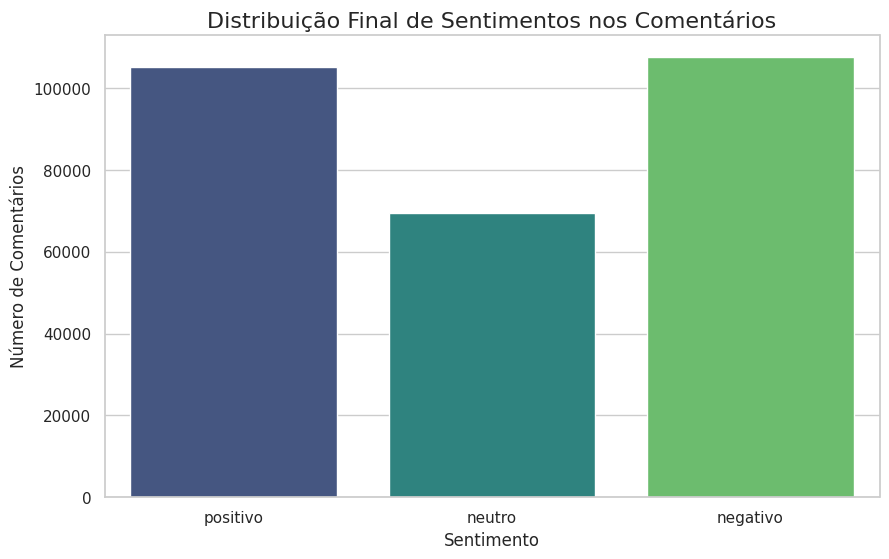

In [ ]:
# Verifica se uma GPU compatível com CUDA está disponível e define o device
device = 0 if torch.cuda.is_available() else -1
print("Usando GPU." if device >= 0 else "Usando CPU para a análise.")

# Carrega o pipeline, passando o device para usar a GPU se disponível
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
    device=device
)
print("Modelo de sentimento carregado com sucesso.")

# Execução da Análise de Sentimento
textos_para_analise = df['texto_limpo'].dropna().tolist()

# Código final com batch_size para performance e truncation para segurança contra erros
resultados = sentiment_pipeline(
    textos_para_analise,
    batch_size=8,          # processa 8 comentários por vez
    truncation=True,       # garante que textos longos sejam cortados
    max_length=512         # limite máximo suportado pelo modelo
)

print("Análise de sentimento completa.")

# Pós-processamento dos resultados
mapeamento_labels = {'positive': 'positivo', 'negative': 'negativo', 'neutral': 'neutro'}
df_resultados = pd.DataFrame(resultados)
df_resultados['sentimento'] = df_resultados['label'].str.lower().map(mapeamento_labels)

# Integra no dataset original
df.loc[df['texto_limpo'].notna(), 'sentimento'] = df_resultados['sentimento'].values
df.loc[df['texto_limpo'].notna(), 'pontuacao_sentimento'] = df_resultados['score'].values

# EXIBE A DISTRIBUIÇÃO FINAL
print("\nDistribuição de Sentimentos:")
display(df['sentimento'].value_counts(normalize=True).mul(100).round(2).to_frame(name='%'))

# Salva o DataSet
caminho_saida = DATA_PROCESSED_DIR / 'comentarios_com_sentimento.csv'
df.to_csv(caminho_saida, index=False)
print(f"\nResultados salvos em '{caminho_saida}'.")

# Gráfico de Distribuição de Sentimento
plt.figure(figsize=(12, 6))
sns.countplot(x='sentimento', data=df, order=['positivo', 'neutro', 'negativo'], palette='viridis', hue='sentimento', legend=False)
plt.title('Distribuição Final de Sentimentos nos Comentários', fontsize=16)
plt.xlabel('Sentimento')
plt.ylabel('Número de Comentários')
plt.show()


### Análise Visual por Sentimento: Nuvens de Palavras

Para aprofundar a compreensão sobre o conteúdo de cada polaridade, geramos nuvens de palavras distintas para os subconjuntos de comentários classificados como "positivos" e "negativos". Esta técnica nos permite visualizar e comparar rapidamente os termos mais proeminentes que caracterizam cada um desses discursos.

**Objetivo:** Identificar o vocabulário central e os focos temáticos que definem as discussões positivas e negativas de forma separada.

**Questão de Pesquisa Específica:** Quais são os termos e conceitos distintos que emergem quando analisamos apenas os comentários positivos em comparação com os negativos?

**Passos da Análise (Metodologia):**
* Filtrar o DataFrame principal para criar dois subconjuntos: um contendo apenas comentários com sentimento `positivo` e outro com sentimento `negativo`.
* Concatenar a coluna `texto_limpo` de cada subconjunto para criar um corpus de texto único para cada sentimento.
* Gerar uma nuvem de palavras individual para cada corpus, utilizando paletas de cores distintas (verdes para positivo, vermelhas para negativo) para reforçar a associação visual.

**Resultados Esperados (Saídas):**
* **Figura 4:** Nuvem de Palavras dos termos mais frequentes nos comentários positivos.
* **Figura 5:** Nuvem de Palavras dos termos mais frequentes nos comentários negativos.

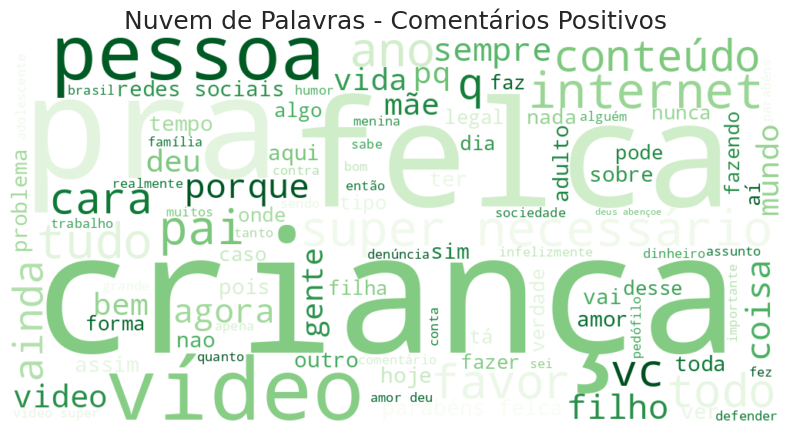

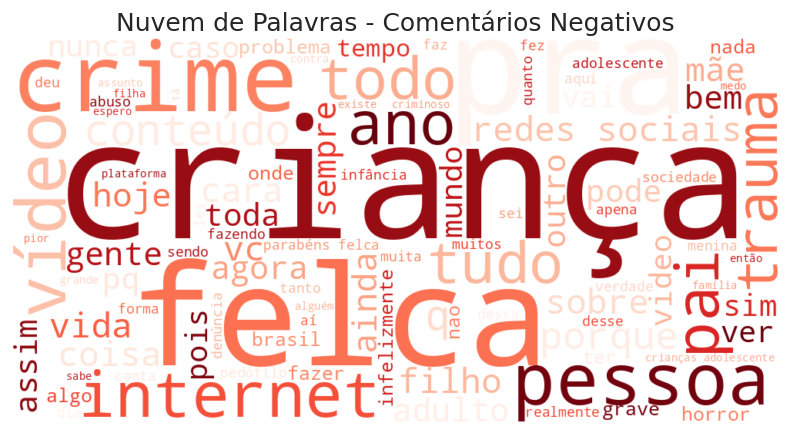

In [15]:
# Filtra o DataFrame para comentários positivos
comentarios_positivos = df[df['sentimento'] == 'positivo']['texto_limpo'].dropna()
texto_positivo = " ".join(comentarios_positivos)

# Filtra o DataFrame para comentários negativos
comentarios_negativos = df[df['sentimento'] == 'negativo']['texto_limpo'].dropna()
texto_negativo = " ".join(comentarios_negativos)

# Nuvem de palavras para comentários positivos
wordcloud_positivo = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='Greens',
    max_words=100,
    min_font_size=10
).generate(texto_positivo)

plt.figure(figsize=(10, 5)) 
plt.imshow(wordcloud_positivo, interpolation='bilinear')
plt.title('Nuvem de Palavras - Comentários Positivos', fontsize=18)
plt.axis('off')
plt.show()

# Nuvem de palavras para comentários negativos
wordcloud_negativo = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='Reds',
    max_words=100,
    min_font_size=10
).generate(texto_negativo)

plt.figure(figsize=(10, 5)) 
plt.imshow(wordcloud_negativo, interpolation='bilinear')
plt.title('Nuvem de Palavras - Comentários Negativos', fontsize=18)
plt.axis('off')
plt.show()